# Analyzing the simulation result

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

ModuleNotFoundError: No module named 'tqdm'

Settings and functions

In [76]:
matplotlib.rcParams.update({
    'figure.dpi': 300,
    'figure.titlesize': 15,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.title_fontsize': 13
})

In [65]:
# busTicketPrice = 15 #; //Placeholder for bus ticket prices to every other zones
# alpha = -0.078725 #f; //$
# beta = -0.020532 #f; //minutes
# basePriceTaxi  = 2.0 #f; //Placeholder, taxi fees per miles
# initialPriceTaxi = 2.5 #f;
# taxiBase = -0.672839 #f;
# busBase = -1.479586 #f;

# taxiUtil = alpha*(initialPriceTaxi+basePriceTaxi*20)+\
#         beta*(100/60+5)+taxiBase #; // assume the waiting time as 5 minute
# busUtil = alpha*busTicketPrice+\
#         beta*(120/60+50/2)+busBase#;

In [3]:
def read_output_veh(data):
    temp = df['vehOnRoad']
    veh_on_road = sum(temp[int((len(temp)+1)/2):])/24
    other_info = df.iloc[-1] - df.iloc[int((len(temp)-1)/2)]
    charge_times = other_info.loc['chargingTrip'].tolist()/24
    
    taxi_data = other_info.loc[['generatedTaxiPass','taxiServedPass','taxiLeavedPass']].tolist()
    bus_data = other_info.loc[['generatedBusPass','busServedPass','busLeavedPass']].tolist()

    taxi_data = np.array(taxi_data)/24
    bus_data = np.array(bus_data)/24
    
    return veh_on_road,charge_times,taxi_data,bus_data

In [4]:
def plot_radar(values, feature, color, label, ax):
    N = len(values)
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)+np.pi/6
    values=np.concatenate((values,[values[0]]))
    angles2=np.concatenate((angles,[angles[0]]))
    ax.plot(angles2, values, 'o-', linewidth=2, label = label, color = color)
    ax.set_thetagrids(angles * 180/np.pi, feature)
    ax.set_ylim(0,1)

In [5]:
def plot_radar_n(values,true_values,feature,colors, labels, ax):
    colors = colors
    nums = values.shape[1]
    N = len(values[:,0])
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    angles2=np.concatenate((angles,[angles[0]]))
    
    for num in range(nums):
        
        plot_value=np.concatenate((values[:,num],[values[:,num][0]]))
        true_value = true_values[:,num]
        plot_radar(values[:,num], feature, colors[num], labels[num], ax)
        n = 0
#         print(true_value)
        for a, b in zip(angles2[:-1], plot_value[:-1]):
            text_n = true_value[n]
            ax.text(a+0.3, b+0.2*(num-2), '%.1f' % text_n, ha='center', va='center', fontsize=10, color=colors[num])
            n+=1
    
    plt.legend(bbox_to_anchor=(1.05, 0.30))
    ax.grid(True)

In [6]:
from sklearn.preprocessing import MinMaxScaler

def fun(data):
    scaler = data/ np.max(data,axis = 0)*0.9
    return scaler#.fit_transform(data)

The names of the files are bad, how to improve it?

Name by distinguishable settings.

# List the summary of all ran instances, also output a remaining list

In [16]:
missing = []
unfinished = []

for eco in ["true", "false"]:
    for bus in ["true", "false"]:
        for share in ['50', '100']:
            for k in range(4):
                for case in range(2):
                    curr_folder = "eco_"+eco+"_bus_"+bus + "_share_" +share + "/scenario"+str(k)+"/"+str(case)+"_1/agg_output/9_3/"
                    
                    if os.path.exists(curr_folder):
                        print("--------------- Scenario " + str(k)+"-------------------")
                        print("Case" + str(case) + " ecorouting:" + eco + " busscheduling:" + bus + " ridehailing ratio:" + share )
                        filenames = os.listdir(curr_folder)
                        #print(filenames)
                        for file in filenames:
                            if "ZoneLog" in file:
                                df_zone = pd.read_csv(curr_folder+file)
                            elif "NetworkLog" in file:
                                df_network = pd.read_csv(curr_folder+file)
                            elif "EVLog" in file:
                                df_ev = pd.read_csv(curr_folder+file)

                        last_time = df_network.iloc[-1]['tick']
                        if(last_time != 48*12000):
                            tmp = "-s " + str(k) + " -c " + str(case) + " -p " + share
                            if eco=="true":
                                tmp+= " -e"
                            if bus=="true":
                                tmp+= " -b"
                            unfinished.append(tmp)
                            continue

                        print("Occupancy rate: " + str(np.mean(df_ev[(df_ev['tripType']==1) & (df_ev['tick']>=12000*24)]['passNum'])))

                        print("Hourly idling mileage:" + str(np.sum(np.sum(df_ev[(df_ev['tripType']==2) & (df_ev['tick']>=12000*24)]['distance'])/1609.1)/(last_time/12000-24)))

                        print("Hourly taxi served passengers: " + str(np.sum(np.sum(df_ev[(df_ev['tripType']==1) & (df_ev['tick']>=12000*24)]['passNum']))/(last_time/12000-24)))

                        print("Hourly bus served passengers: " + str((np.sum(df_zone[df_zone['tick']==last_time]['busServedPass']) - np.sum(df_zone[df_zone['tick']==24*12000]['busServedPass']))/(last_time/12000-24)))

                        print("Hourly left passengers: " + str((df_network[df_network['tick']==last_time]['taxiLeavedPass'].values[0]-df_network[df_network['tick']==12000*24]['taxiLeavedPass'].values[0])\
                                                               /(last_time/12000-24)))

                        print("Average passenger waiting time (h) for taxi: " +str((np.sum(df_network[(df_network['tick']<=last_time)&(df_network['tick']>=12000*24)]['numWaitingTaxiPass'])*600-df_network[df_network['tick']==last_time]['taxiLeavedPass'].values[0]*24000\
                                                               +df_network[df_network['tick']==12000*24]['taxiLeavedPass'].values[0]*24000)/np.sum(df_ev[(df_ev['tripType']==1) & (df_ev['tick']>=12000*24)]['passNum'])/12000))

                        print("Average passenger waiting time (h) for bus: " +str((np.sum(df_network[(df_network['tick']<=last_time)&(df_network['tick']>=12000*24)]['numWaitingBusPass'])*600-df_network[df_network['tick']==last_time]['busLeavedPass'].values[0]*24000\
                                                               +df_network[df_network['tick']==12000*24]['busLeavedPass'].values[0]*24000)/(np.sum(df_zone[df_zone['tick']==last_time]['busServedPass']) - np.sum(df_zone[df_zone['tick']==24*12000]['busServedPass']))/12000))

                        print("Energy consumption (kwh) per hour: " + str(np.sum(np.sum(df_ev[(df_ev['tick']<=last_time)]['cost']))/(last_time/12000-24)))
                    else:
                        tmp = "-s " + str(k) + " -c " + str(case) + " -p " + str(int(share)/100)
                        if eco=="true":
                            tmp+= " -e"
                        if bus=="true":
                            tmp+= " -b"
                        missing.append(tmp)

--------------- Scenario 0-------------------
Case0 ecorouting:true busscheduling:true ridehailing ratio:50
Occupancy rate: 1.0994828238657866
Hourly idling mileage:16958.373161621406
Hourly taxi served passengers: 1089.5416666666667
Hourly bus served passengers: 389.4583333333333
Hourly left passengers: 6.583333333333333
Average passenger waiting time (h) for taxi: 0.09952770660445907
Average passenger waiting time (h) for bus: 0.7893013801219644
Energy consumption (kwh) per hour: 4655.240477002117
--------------- Scenario 0-------------------
Case1 ecorouting:true busscheduling:true ridehailing ratio:50
Occupancy rate: 1.1357038263194754
Hourly idling mileage:29778.333887619894
Hourly taxi served passengers: 1486.5416666666667
Hourly bus served passengers: 470.9166666666667
Hourly left passengers: 16.333333333333332
Average passenger waiting time (h) for taxi: 0.14376348908260222
Average passenger waiting time (h) for bus: 0.7383693151654575
Energy consumption (kwh) per hour: 6239.94

In [18]:
unfinished

['-s 1 -c 1 -p 50']

In [4]:
missing

[]

In [17]:
unfinished

['-s 1 -c 1 -p 50']

# TODO: plot the figures

In [7]:
# Get the available settings
def processing(setting):
    avail_output = {}
    for file in os.listdir(setting):
        scenario  = file.split("_")[0]
        if scenario not in avail_output:
            avail_output[scenario] = []
        avail_output[scenario].append(file)
    # Read the metrics
    occu_rate = {}
    idling_mileage= {}
    served_pass = {}
    left_pass = {}
    wait_time = {}
    ener_cons = {}
    for scenario in range(4):
        scenario_key = "scenario"+str(scenario)
        for item in avail_output[scenario_key]:
            curr_folder = setting + "/" + item  + "/agg_output/7_2/" # TODO: replace the hardcoding part
            try:
                filenames = os.listdir(curr_folder)

                if(scenario not in occu_rate):
                    occu_rate[scenario] = []
                    idling_mileage[scenario]= []
                    served_pass[scenario] = []
                    left_pass[scenario] = []
                    wait_time[scenario] = []
                    ener_cons[scenario] = []
                # filenames = os.listdir(curr_folder)
            
                for file in filenames:
                    if "ZoneLog" in file:
                        df_zone = pd.read_csv(curr_folder+file)
                    elif "NetworkLog" in file:
                        df_network = pd.read_csv(curr_folder+file)
                    elif "EVLog" in file:
                        df_ev = pd.read_csv(curr_folder+file)
                last_time = df_network.iloc[-1]['tick']
                if(len(df_zone) == 0 or len(df_network) <10 or len(df_ev) == 0 or last_time<12000*24 ):
                    print(setting+" "+ scenario_key+" is broken")
                    continue
            except:
                print(setting+" "+ scenario_key+" is damaged")
                continue
            # start from the second day
            occu_rate[scenario].append(np.mean(df_ev[(df_ev['tripType']==1) & (df_ev['tick']>=12000*24)]['passNum']))
            idling_mileage[scenario].append(np.sum(np.sum(df_ev[(df_ev['tripType']==2) & (df_ev['tick']>=12000*24)]['distance'])/1609.1)/(last_time/12000-24))
            served_pass[scenario].append(np.sum(np.sum(df_ev[(df_ev['tripType']==1) & (df_ev['tick']>=12000*24)]['passNum']))/(last_time/12000-24))
            left_pass[scenario].append((df_network[df_network['tick']==last_time]['taxiLeavedPass'].values[0]-df_network[df_network['tick']==12000*24]['taxiLeavedPass'].values[0])\
                                       /(last_time/12000-24))
            wait_time[scenario].append((np.sum(df_network[(df_network['tick']<=last_time)&(df_network['tick']>=12000*24)]['numWaitingTaxiPass'])*600-df_network[df_network['tick']==last_time]['taxiLeavedPass'].values[0]*6000\
                                       +df_network[df_network['tick']==12000*24]['taxiLeavedPass'].values[0]*6000)/12000/np.sum(df_ev[(df_ev['tripType']==1) & (df_ev['tick']>=12000*24)]['passNum']))
            ener_cons[scenario].append(np.sum(np.sum(df_ev[(df_ev['tick']<=last_time)]['cost']))/(last_time/12000-24))
    return occu_rate, idling_mileage, served_pass, left_pass, wait_time, ener_cons

In [8]:
# files = ['scenario0_0/agg_output/5_1/NetworkLog-2021-11-20-11-52-18.csv',
#          'scenario1/agg_output/5_1/NetworkLog-2021-11-20-11-53-22.csv',
#         'scenario2/agg_output/5_1/NetworkLog-2021-11-20-11-58-32.csv', 
#          'scenario3/agg_output/5_1/NetworkLog-2021-11-20-11-59-19.csv']
# labels = ['Scenario0','Scenario1','Scenario2','Scenario3']

# veh_on_road_dict = []; charge_times_dict = []; taxi_data_dict = []; bus_data_dict = []
# for file in files:
#     df = pd.read_csv(file)
#     out1, out2, out3, out4 = read_output_veh(df)
#     veh_on_road_dict.append(out1)
#     charge_times_dict.append(out2)
#     taxi_data_dict.append(out3)
#     bus_data_dict.append(out4)
# # plt.style.use('ggplot')
# original_data = np.concatenate([np.stack(taxi_data_dict).T,np.stack(bus_data_dict).T])
# taxi_data_dict = fun(np.stack(taxi_data_dict)).T
# bus_data_dict = fun(np.stack(bus_data_dict)).T
# all_data = np.concatenate([taxi_data_dict, bus_data_dict])

In [9]:
def plot_radar_n(values,true_values,feature,colors, labels, ax):
    colors = colors
    nums = values.shape[1]
    N = len(values[:,0])
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    angles2=np.concatenate((angles,[angles[0]]))
    for num in range(nums):
        plot_value=np.concatenate((values[:,num],[values[:,num][0]]))
        true_value = true_values[:,num]
        plot_radar(values[:,num], feature, colors[num], labels[num], ax)
        n = 0
#         print(true_value)
        for a, b in zip(angles2[:-1], plot_value[:-1]):
            text_n = true_value[n]
            ax.text(a+0.3, b+0.07*(num), '%.1f' % text_n, ha='center', va='center', fontsize=10, color=colors[num])
            n+=1
#     plt.legend(bbox_to_anchor=(1.05, 0.30))
    ax.grid(True)

In [ ]:
occu_rate1, idling_mileage1, served_pass1, left_pass1, wait_time1, ener_cons1 = processing("Temp2")
occu_rate2, idling_mileage2, served_pass2, left_pass2, wait_time2, ener_cons2 = processing("Ridesharing_no_bus_no_ecorouting")
occu_rate3, idling_mileage3, served_pass3, left_pass3, wait_time3, ener_cons3 = processing("Temp")
occu_rate4, idling_mileage4, served_pass4, left_pass4, wait_time4, ener_cons4 = processing("Ridesharing_with_bus_no_ecorouting")

KeyError: 'scenario0'

In [45]:
feature_veh = ['Occupancy rate',
               'Idling mileage','Served passengers', 'Left passengers',
               'Waiting time (min)',
               'Energy consumption (kwh)']

1. Ridesharing case record of served passengers in zone class is incorrect
2. Number of generated passengers in current implementation is inaccurate
3. Bus split ratio is missing
    + 230 Distance (Zengxiang)
    + 230 Taxi Time (Zengxiang)
    + Utility function (Zengxiang)
    + Fixed route, vehicle number
4. Visualize every scenario (Zhenyu)

In [49]:
original_data[:,2] + original_data[:,3]

array([2124.91666667, 2397.06458333, 2409.16666667,  644.33333333])

In [47]:
original_data

array([[1.00000000e+00, 4.16174991e+04, 1.37495833e+03, 7.49958333e+02,
        1.31101278e+00, 1.13089992e+04],
       [2.50019726e+00, 3.15704902e+02, 8.30654167e+02, 1.56641042e+03,
        3.50073754e+01, 2.02907918e+03],
       [2.50011451e+00, 1.59672591e+02, 7.98552083e+02, 1.61061458e+03,
        3.83856213e+01, 2.12211494e+03],
       [           nan, 9.11457226e+01, 1.81888889e+02, 4.62444444e+02,
                   inf, 1.45923532e+05]])

In [46]:
feature_veh

['Occupancy rate',
 'Idling mileage',
 'Served passengers',
 'Left passengers',
 'Waiting time (min)',
 'Energy consumption (kwh)']

C:\Users\User\AppData\Local\Temp/ipykernel_14100/2531009030.py:4: RuntimeWarning: invalid value encountered in true_divide
  scaler = data/ np.max(data,axis = 0)*0.9


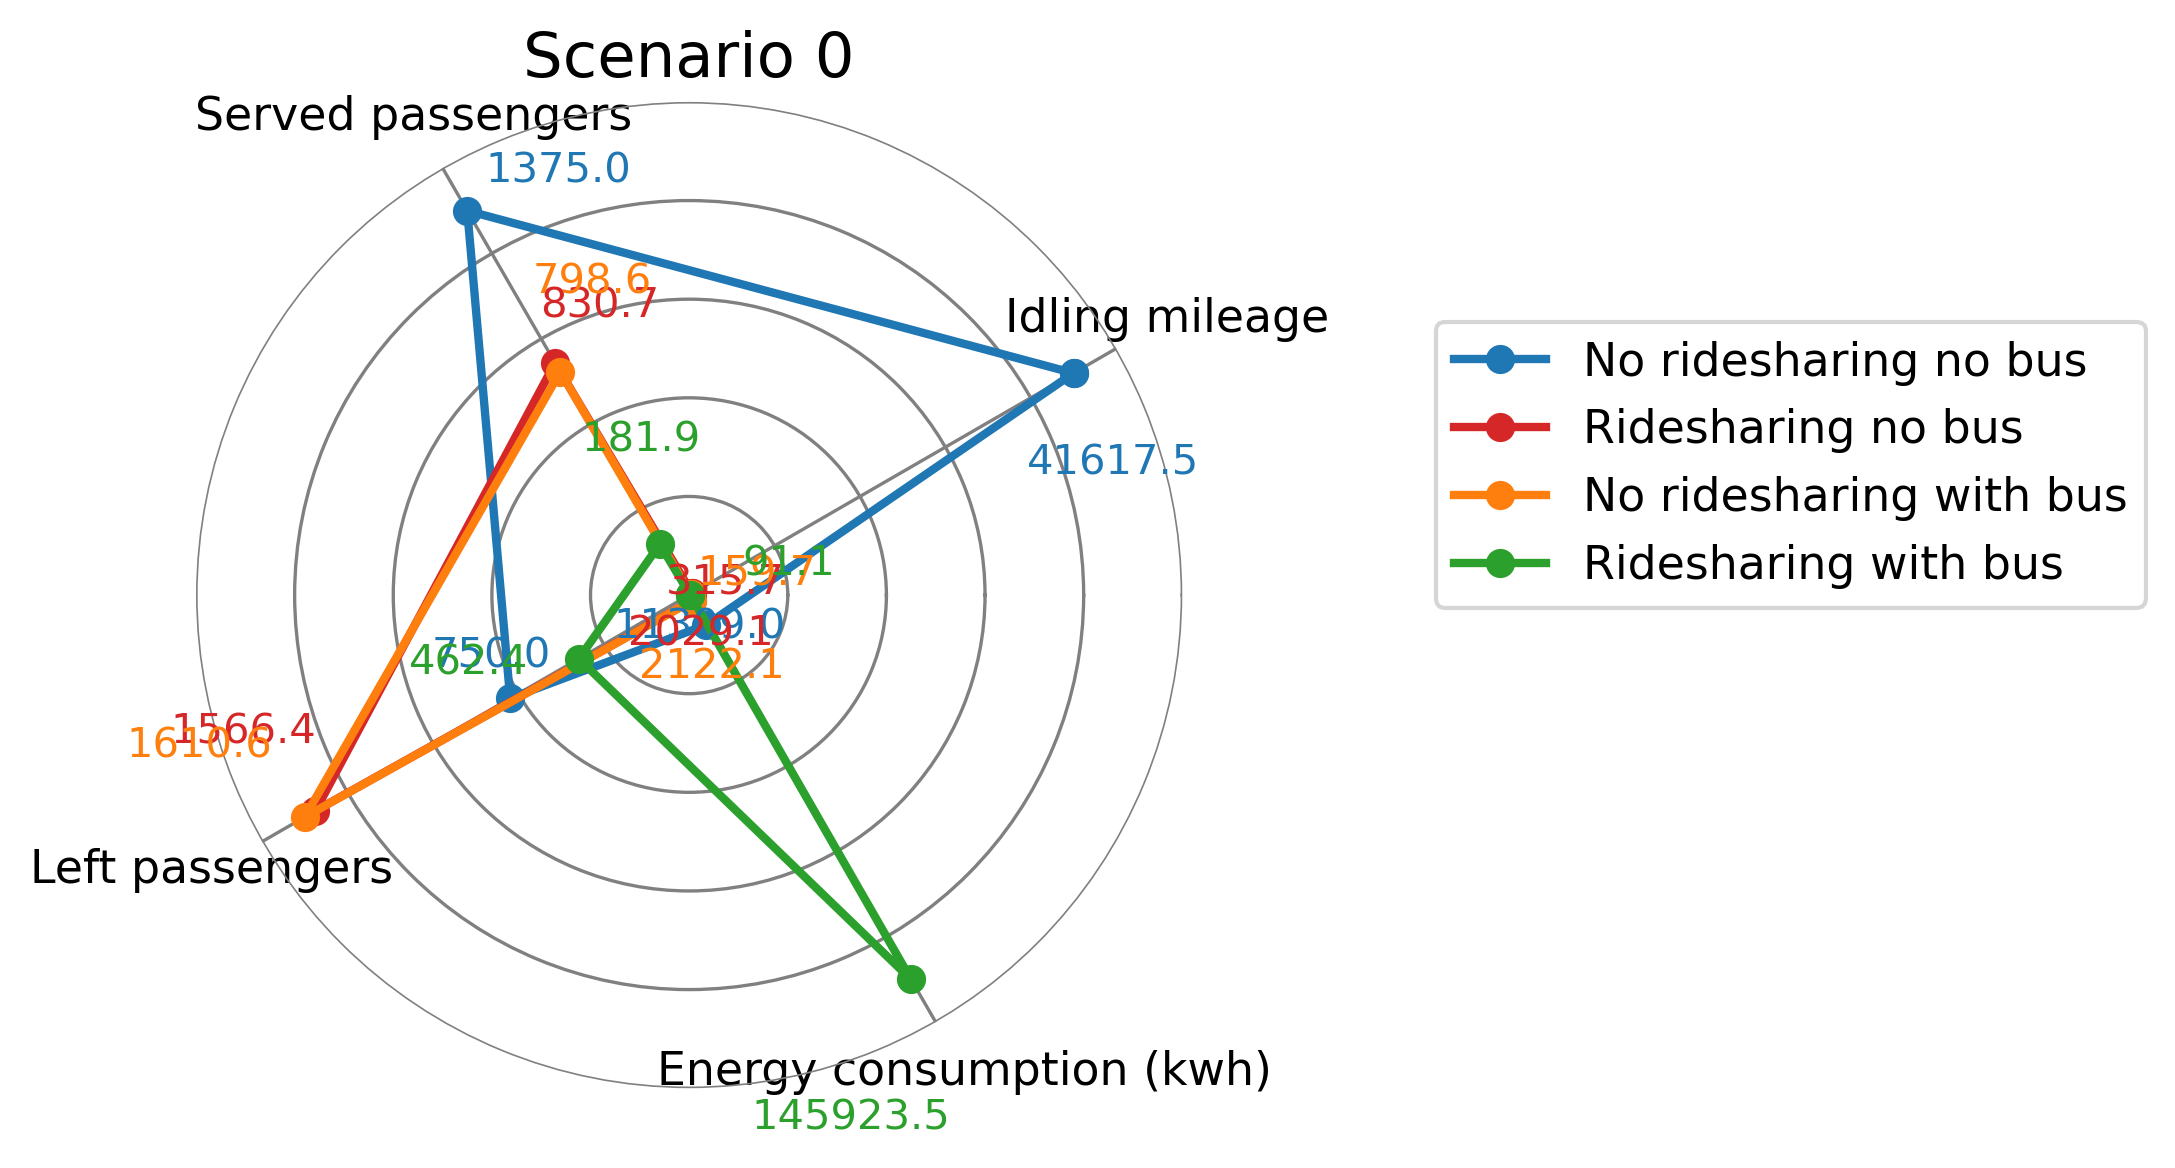

In [42]:
i = 0

original_data = np.array([[np.mean(occu_rate1[i]),np.mean(idling_mileage1[i]),np.mean(served_pass1[i]),np.mean(left_pass1[i]),np.mean(wait_time1[i]),np.mean(ener_cons1[i])],
                          [np.mean(occu_rate2[i]),np.mean(idling_mileage2[i]),np.mean(served_pass2[i]),np.mean(left_pass2[i]),np.mean(wait_time2[i]),np.mean(ener_cons2[i])],
                          [np.mean(occu_rate3[i]),np.mean(idling_mileage3[i]),np.mean(served_pass3[i]),np.mean(left_pass3[i]),np.mean(wait_time3[i]),np.mean(ener_cons3[i])],
                         [np.mean(occu_rate4[i]),np.mean(idling_mileage4[i]),np.mean(served_pass4[i]),np.mean(left_pass4[i]),np.mean(wait_time4[i]),np.mean(ener_cons4[i])]])
all_data = fun(np.stack(original_data)).T

labels = ['No ridesharing no bus', 'Ridesharing no bus', 'No ridesharing with bus' ,'Ridesharing with bus']
fig,ax_old = plt.subplots(figsize=(6,4))
ax = fig.add_subplot(111, polar=True)
ax.set_facecolor('w') 
ax.grid(color="gray") 
#ax.grid(False)    
ax_old.axis('Off')
ax.spines['polar'].set_visible(False)  
feature_veh = [#'Occupancy rate',
               'Idling mileage','Served passengers', 'Left passengers',
               #'Waiting time (min)',
               'Energy consumption (kwh)']
title = 'Taxi results'
file_name = 'taxi'
#sns.color_palette("tab10", len(labels))
plot_radar_n(all_data[[1,2,3,5],:],original_data.T[[1,2,3,5],:],feature_veh,['C0','C3', 'C1','C2'],labels, ax)
ax.set_yticklabels([])
plt.tight_layout()
plt.title("Scenario " + str(i))

plt.legend(bbox_to_anchor=(2.,0.8), loc="upper right")

plt.tight_layout()

plt.savefig('figs/radar_'+str(i)+'.pdf')
plt.savefig('figs/radar_'+str(i)+'.png', dpi = 300)

Why choosing these metrics? Is this energy consumption reasonable?

In [53]:
# Default bus routes
{
"names":[10001,10002,10003,10004,10005,10006,10007,10008,10009,100010,100011,100012,100013,100014,100015,100016,100017,100018],
"routes":[[132,138,262,263,141,237,163,142,48,230,163,162,161,164],[132,164,170,233,162,161,230,48,143,50,143,237,141,229],
[132,100,186,68,90,234,113,249,158,249,100,186],[132,137,107,79,148,144,231,144,148,256,255],
[132,218,10,236,238,239,238,43,236,263,262],[132,7,50,246,68,90,234,107,79],[132,216,61,188,62,181,61,177,77],
[132,145,209,87,261,13,125,13,261,88,87],[132,37,225,17,49,97,25,97,17],
[132,219,74,41,151,166,151,24,41,74],[132,95,196,33,65,189,62,188,71,72],
[132,112,255,256,211,125,4,224],[132,135,82,66,49,225,37,36],
[132,197,258,114,113,137,219],[132,226,229,140,43,140,75],
[132,39,91,165,133,40,257,89,165,91],[132,134,102,198,36,198,102,258],[132,124,76,72,71,89,133,178,123,149]],
"nums":[50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50],
"gaps":[21,23,31,31,37,37,32,48,36,51,46,47,46,53,52,56,47,53]
}

print("")

In [50]:
# Mode split formula
alpha = -0.078725 # $
beta = -0.020532 # minute
initialPriceTaxi = 2.5
basePriceTaxi = 0.9695
taxiBase = -0.672839 
busTicketPrice = 10
busBase = -1.479586

taxiUtil = alpha*(initialPriceTaxi+basePriceTaxi*taxiTravelDistance[originID,destID])+ \
                   beta*(taxiTravelTime[originID,destID]/60+5)+taxiBase

busUtil = (float) (alpha*busTicketPrice+ \
                   beta*(busTravelTime[originID,destID]/60+this.busGap/2)+busBase)

split_ratio = np.exp(busUtil)/(np.exp(busUtil)+np.exp(taxiUtil))

In [81]:
import geopandas as gp
import networkx as nx
import pandas as pd
import time
import random
from scipy.spatial import cKDTree 
from shapely.geometry import LineString, shape,Point

In [97]:
# Helper functions
def ckdnearest(gdA, gdB,acol, bcol):   
    nA = list(gdA['geometry'].apply(getXY))
    nB = list(gdB['geometry'].apply(getXY))
    from rtree import index
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    gdA['distance']=dist.astype(float)
    for b in bcol:
        gdA[b]=gdB.loc[idx, b].values
    return gdA

def getXY(geo):
    pt=geo.representative_point()
    return (pt.x, pt.y)

def eval_list(a,ind=0):
    return a[ind]

def get_coordinates(a):
    l=list(a.coords)
    return l

def create(poin):
    return Point(poin)

def get_cords_multipol(pol):
    cords=[]
    for i in range(len(pol)):
        p=pol[i]
        cords.extend(list(p.exterior.coords))
    return cords

def extract_geometry(df):
    ext=[]
    cols=list(df.columns)
    cols.remove('cords')
    cols.remove('geometry')
    for i in df.index:
        cords=df.loc[i,'cords']
        props=df.loc[i, cols].values.tolist()
        ext.append(props+[df.loc[i,'geometry'].representative_point()])
        ext.append(props+[Point(cords)])
    cols2=cols+['geometry'] 
    points=pd.DataFrame(ext,columns=cols2)
    return gp.GeoDataFrame(points, geometry='geometry',crs=df.crs) 

In [ ]:
target_map = gpd.read_file("../road_fileNYC.shp")
target_zone = gpd.read_file("../NYC_zone_wgs84.shp")

In [133]:
# extract road/zone information
target_map['cords']=target_map['geometry'].apply(get_coordinates)
target_map['cord_f']=target_map['cords'].apply(eval_list, args=(-1,))
target_map['cord_i']=target_map['cords'].apply(eval_list, args=(0,))

nodes1=target_map.loc[:,['FN','cord_i']]
nodes1=nodes1.rename(columns={'FN':'nod_i','cord_i':'cords'})
nodes2=target_map.loc[:,['TN','cord_f']]
nodes2=nodes2.rename(columns={'TN':'nod_i','cord_f':'cords'})
nodes=nodes1.append(nodes2)
nod=nodes.groupby('nod_i')

nodes_fi=nod.agg({'nod_i':list,'cords':list})
nodes_fi['nod_i1']=nodes_fi['nod_i'].apply(eval_list)
nodes_fi['cords1']=nodes_fi['cords'].apply(eval_list)
nodes_fi=nodes_fi.drop(['nod_i', 'cords'], axis=1).rename(columns={'cords1':'cords','nod_i1':'nod_i'})

nodes_fi['geometry']=nodes_fi['cords'].apply(create)
nodes_e=gp.GeoDataFrame(nodes_fi, geometry='geometry')

target_zone['cords']=target_zone['geometry'].centroid
nodes_extracted=extract_geometry(target_zone) 

df33= gp.sjoin(nodes_e, target_zone, how="left", op='intersects')
df22=df33[df33['LocationID'].isnull()]
df22=df22.loc[:,['nod_i','geometry','zone','LocationID','borough']]
df22_matched=ckdnearest(df22,nodes_extracted,'nod_i',['LocationID','zone','borough'])
df22=df22.loc[:,['nod_i','geometry','zone','LocationID','borough']]
df33=df33.loc[:,['nod_i','geometry','zone','LocationID','borough']]
df33=df33.dropna()
df4=df33.append(df22)

C:\Users\User\AppData\Local\Temp/ipykernel_14100/253411513.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  target_zone['cords']=target_zone['geometry'].centroid
C:\Users\User\AppData\Local\Temp/ipykernel_14100/253411513.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df33= gp.sjoin(nodes_e, target_zone, how="left", op='intersects')


In [102]:
# generate shortest path, replace the weight to get different matrix
G=nx.from_pandas_edgelist(target_map, 'FN', 'TN',True)
paths2=nx.shortest_path(G,weight='length')
keys_p=list(paths2.keys())

In [134]:
# # This parth creates the matrix of original links to links (subset)
# nodes_e = gpd.sjoin(nodes_e, target_zone, how = 'left')
# nodes_e=nodes_e.set_index('nod_i')
# nodes_e['nod_i']=list(nodes_e.index.values)
# nodes_e['nod_i']=list(nodes_e.index.values)
# di=nodes_e.groupby('LocationID')
# list_loc=di.agg({'nod_i':list}).reset_index()
# list_loc['len']=list_loc['nod_i'].apply(len)
# pathsrandom=[]
# for i in list_loc.index.values:
#     kk=int(list_loc.loc[i,'len']/4)
#     lista1=list_loc.loc[i,'nod_i']
#     pathsrandom.append(lista1)
# pathsrandom=random.choices(list(paths2.keys()), k=int(len(paths2.keys())/4))
# mat2=np.zeros([len(pathsrandom),len(pathsrandom),3])
# cont=0
# i=-1
# ori=pathsrandom
# dis={}

# for key1 in pathsrandom:
#    i=i+1
#    pel=ori[i::]
#    cont=cont+1
#    #print(cont/len(pathsrandom))
#    dis[key1]={}
#    j=i-1
#    for key2 in pel:   
#        j=j+1
#        path=paths2[key1][key2]
#        distance=0
#        timew=0
#        a2=path[0]
#        dis[key1][key2]=path
#        for p in range(len(path)-1):
#            a1=a2
#            a2=path[p+1] 
#            props=G[a1][a2]
#            distance=distance+props['length']  
#            timew=timew+props['length']  
#        mat2[i,j,0]=distance
#        mat2[i,j,1]=timew
#        mat2[j,i,0]=distance
#        mat2[j,i,1]=timew
   
# mat2[:,:,2]=mat2[:,:,0]/(mat2[:,:,1]*60)*3.6      
# mat2[:,:,2][np.isnan(mat2[:,:,2])] = 0

C:\Users\User\AppData\Local\Temp/ipykernel_14100/271771213.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  nodes_e = gpd.sjoin(nodes_e, target_zone, how = 'left')


0.0007974481658692185
0.001594896331738437
0.0023923444976076554
0.003189792663476874
0.003987240829346092
0.004784688995215311
0.005582137161084529
0.006379585326953748
0.007177033492822967
0.007974481658692184
0.008771929824561403
0.009569377990430622
0.01036682615629984
0.011164274322169059
0.011961722488038277
0.012759170653907496
0.013556618819776715
0.014354066985645933
0.015151515151515152
0.01594896331738437
0.01674641148325359
0.017543859649122806
0.018341307814992026
0.019138755980861243
0.019936204146730464
0.02073365231259968
0.0215311004784689
0.022328548644338118
0.023125996810207338
0.023923444976076555
0.024720893141945772
0.025518341307814992
0.02631578947368421
0.02711323763955343
0.027910685805422646
0.028708133971291867
0.029505582137161084
0.030303030303030304
0.03110047846889952
0.03189792663476874
0.03269537480063796
0.03349282296650718
0.0342902711323764
0.03508771929824561
0.03588516746411483
0.03668261562998405
0.037480063795853266
0.03827751196172249
0.039074

C:\Users\User\AppData\Local\Temp/ipykernel_14100/271771213.py:46: RuntimeWarning: invalid value encountered in true_divide
  mat2[:,:,2]=mat2[:,:,0]/(mat2[:,:,1]*60)*3.6


In [173]:
# create a map from target map to networkx Graph so we can update the speed parameter
selected_index = []
j = 0
for i in range(len(target_map)):
    row = target_map.iloc[i]
    if((row['FN'], row['TN']) in list(G.edges.keys())[j:]):
        selected_index.append(i)
        j += 1
        print(j)
        if(j == len(G.edges)):
            break

(10524, 49)

In [176]:
# load the speed info
for scenario in ["scenario0", "scenario1", "scenario2", "scenario3"]:
    files = os.listdir("../0_FINAL/Dataset/speed/"+scenario+"/")
    for file in files:
        if(file.startswith("speed_2019")):
            speed_data = pd.read_csv("../0_FINAL/Dataset/speed/"+scenario+"/" + file)
            df2=ckdnearest(target_zone, nodes_e,'LocationID',['nod_i'])      
            points=df2['nod_i']
            matrix2=np.zeros([len(points),len(points),49])
            d=0
            for i in range(len(points)):
                for j in range(len(points)):
                    d=d+1
                    # print(d/len(points)**2)
                    path=paths2[points[i]][points[j]]
                    dist=0
                    for p in range(len(path)-1):
                        dist=dist+G[path[p]][path[p+1]]['length']
                    matrix2[i,j,0]=dist
            
            for k in range(1,49):
                nx.set_edge_attributes(G, (target_map['length'].values/speed_data.iloc[:,k].values/1609*3600)[selected_index], "time")
                # This part creates the inter-zone matrix
                d=0
                for i in range(len(points)):
                    for j in range(len(points)):
                        d=d+1
                        # print(d/len(points)**2)
                        path=paths2[points[i]][points[j]]
                        time=0
                        for p in range(len(path)-1):
                            time=time+G[path[p]][path[p+1]]['time']
                        matrix2[i,j,k]=time
            np.save("to_jiawei/"+scenario+"_"+file[:-4]+".npy",matrix2)

ValueError: setting an array element with a sequence.

In [ ]:
selected_index = []

for key1 in list(G.edges.keys()):
    for i in range(len(target_map)):
        row = target_map.iloc[i]
        if((row['FN'], row['TN']) == key1):
            selected_index.append(i)

In [ ]:
len(selected_index)